# check for TOC

In [1]:
import pymupdf
import os

base_folder = "/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/"

files_with_toc = []
files_without_toc = []

for root, dirs, files in os.walk(base_folder):
    for file in files:
        if file.endswith(".pdf"):
            file_path = os.path.join(root, file)
            doc = pymupdf.open(file_path)
            toc = doc.get_toc()
            if len(toc) > 0:
                files_with_toc.append({"path": file_path, "toc": toc})
            else:
                files_without_toc.append(file_path)
            # print(f"TOC for {file_path}:")
            # print(toc)

In [2]:
len(files_with_toc)

43

In [3]:
len(files_without_toc)

37

# Extract TOC with Markdown

In [4]:
import pymupdf

doc = pymupdf.open("/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/Berlinovo/Finanzbericht_Berlinovo_2022_bf_s.pdf")
toc = doc.get_toc()
# toc

In [5]:
import pandas as pd

def enumerate_toc(hierarchy_levels):
    enumeration = []
    stack = []
    for level in hierarchy_levels:
        # Adjust stack to current level
        while len(stack) > level:
            stack.pop()
        if len(stack) < level:
            stack += [0] * (level - len(stack))
        # Increment current level
        stack[-1] += 1
        # Reset lower levels
        for i in range(level, len(stack)):
            stack[i] = 0
        # Build enumeration string
        enum_str = ".".join(str(num) for num in stack if num > 0)
        enumeration.append(enum_str)
    return enumeration

def generate_markdown_toc(toc):
    toc_df = pd.DataFrame(toc, columns=["hierarchy_level", "title", "page_number"])
    toc_df["enumeration"] = enumerate_toc(toc_df["hierarchy_level"].tolist())
    toc_markdown = toc_df.to_markdown(index=False)
    return toc_markdown

for item in files_with_toc:
    item['n_entries'] = len(item['toc'])
    item['markdown_toc'] = generate_markdown_toc(item['toc'])

files_with_toc

[{'path': '/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf',
  'toc': [[1, 'Lagebericht', 5],
   [1, 'Bilanz', 7],
   [1, 'Gewinn- und Verlustrechnung', 10],
   [1, 'Anhang', 13],
   [1, 'Lagebericht ', 17],
   [1, 'Bilanz', 25],
   [1, 'Anhang', 31],
   [1, 'Anlagenspiegel', 39],
   [1, 'Bestätigungsvermerk', 42]],
  'n_entries': 9,
  'markdown_toc': '|   hierarchy_level | title                       |   page_number |   enumeration |\n|------------------:|:----------------------------|--------------:|--------------:|\n|                 1 | Lagebericht                 |             5 |             1 |\n|                 1 | Bilanz                      |             7 |             2 |\n|                 1 | Gewinn- und Verlustrechnung |            10 |             3 |\n|                 1 | Anhang                      |            13 |             4 |\n|                 1 | Lagebericht                 |            17 |         

In [6]:
toc_data = {
    "files_with_toc": files_with_toc,
    "files_without_toc": files_without_toc
}

In [ ]:
import json

with open("../../benchmark_truth/toc_data.json", "w") as f:
    json.dump(toc_data, f, indent=4)


# Work with the machine readable TOC

In [7]:
pd.DataFrame(toc_data["files_with_toc"][0]['toc'], columns=["hierarchy_level", "title", "page_number"]).to_json(index=False, orient="records")

'[{"hierarchy_level":1,"title":"Lagebericht","page_number":5},{"hierarchy_level":1,"title":"Bilanz","page_number":7},{"hierarchy_level":1,"title":"Gewinn- und Verlustrechnung","page_number":10},{"hierarchy_level":1,"title":"Anhang","page_number":13},{"hierarchy_level":1,"title":"Lagebericht ","page_number":17},{"hierarchy_level":1,"title":"Bilanz","page_number":25},{"hierarchy_level":1,"title":"Anhang","page_number":31},{"hierarchy_level":1,"title":"Anlagenspiegel","page_number":39},{"hierarchy_level":1,"title":"Best\\u00e4tigungsvermerk","page_number":42}]'

In [8]:
toc_markdown = toc_data["files_with_toc"][0]["markdown_toc"]
print(toc_markdown)

|   hierarchy_level | title                       |   page_number |   enumeration |
|------------------:|:----------------------------|--------------:|--------------:|
|                 1 | Lagebericht                 |             5 |             1 |
|                 1 | Bilanz                      |             7 |             2 |
|                 1 | Gewinn- und Verlustrechnung |            10 |             3 |
|                 1 | Anhang                      |            13 |             4 |
|                 1 | Lagebericht                 |            17 |             5 |
|                 1 | Bilanz                      |            25 |             6 |
|                 1 | Anhang                      |            31 |             7 |
|                 1 | Anlagenspiegel              |            39 |             8 |
|                 1 | Bestätigungsvermerk         |            42 |             9 |


In [9]:
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:8000/v1",
    api_key="sk-1234567890abcdef1234567890abcdef1234567890abcdef1234567890abcdef",
)

models = client.models.list()
model = models.data[0].id
print(f"Using model: {model}")

Using model: mistralai/Ministral-8B-Instruct-2410


## simple request

In [10]:
def combine_messages(messages):
    """
    Combines subsequent dicts in a list with the same 'role' by joining their 'content' strings.
    Args:
        messages (list of dict): Each dict must have 'role' and 'content' keys.
    Returns:
        list of dict: Combined messages.
    """
    if not messages:
        return []

    combined = [messages[0].copy()]
    for msg in messages[1:]:
        if msg["role"] == combined[-1]["role"]:
            combined[-1]["content"] += "\n" + msg["content"]
        else:
            combined.append(msg.copy())
    return combined

In [11]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report, that can be found based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which page is the win and loss statement (in German: Gewinn- und Verlustrechnung) located?"},
    {"role": "assistant", "content": f"The win and loss statement can be found on page "}
]

In [12]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    # extra_body={
    #     "guided_grammar": ebnf_grammar,
    #     # 'use_beam_search': True
    # },
    max_tokens=1000,
    temperature=0.2,
)

result = completion.choices[0].message.content

In [13]:
result

'The win and loss statement (Gewinn- und Verlustrechnung) is located on page 10.'

In [14]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report, that can be found based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which page is the balance sheets (in German: Bilanz) located? Give seperate answers for the liabilities and assets table."},
    {"role": "assistant", "content": f"The balance sheet can be found on the pages "}
]

In [15]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    # extra_body={
    #     "guided_grammar": ebnf_grammar,
    #     # 'use_beam_search': True
    # },
    max_tokens=1000,
    temperature=0.2,
)

result = completion.choices[0].message.content

In [16]:
result

'The balance sheet (Bilanz) is located on the following pages:\n\n- Liabilities and Assets Table: Page 7'

In [17]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report, that can be found based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which page are the win and loss statement (in German: Gewinn- und Verlustrechnung) and the balance sheets (German: Bilanz) located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    {"role": "user", "content": f"Answer in JSON format with keys 'liabilities', 'assets', and 'win_loss_statement' and the page numbers as values."},
]
combine_messages(messages)

[{'role': 'system',
  'content': 'You are a helpful assistant that can determine the page range information in a German financial report, that can be found based on the documents table of contents.'},
 {'role': 'user',
  'content': "This is the table of contents:\n\n|   hierarchy_level | title                       |   page_number |   enumeration |\n|------------------:|:----------------------------|--------------:|--------------:|\n|                 1 | Lagebericht                 |             5 |             1 |\n|                 1 | Bilanz                      |             7 |             2 |\n|                 1 | Gewinn- und Verlustrechnung |            10 |             3 |\n|                 1 | Anhang                      |            13 |             4 |\n|                 1 | Lagebericht                 |            17 |             5 |\n|                 1 | Bilanz                      |            25 |             6 |\n|                 1 | Anhang                      |  

In [18]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    # extra_body={
    #     "guided_grammar": ebnf_grammar,
    #     # 'use_beam_search': True
    # },
    max_tokens=1000,
    temperature=0.2,
)

result = completion.choices[0].message.content

In [19]:
result

'```json\n{\n  "assets": 7,\n  "liabilities": 7,\n  "win_loss_statement": 10\n}\n```'

## structured generation

In [20]:
from pydantic import BaseModel
# from enum import Enum

# class CarType(str, Enum):
#     sedan = "sedan"
#     suv = "SUV"
#     truck = "Truck"
#     coupe = "Coupe"

class TOCEntry(BaseModel):
    title: str
    page: int

class TOC(BaseModel):
    entries: list[TOCEntry]

json_schema = TOC.model_json_schema()
json_schema

{'$defs': {'TOCEntry': {'properties': {'title': {'title': 'Title',
     'type': 'string'},
    'page': {'title': 'Page', 'type': 'integer'}},
   'required': ['title', 'page'],
   'title': 'TOCEntry',
   'type': 'object'}},
 'properties': {'entries': {'items': {'$ref': '#/$defs/TOCEntry'},
   'title': 'Entries',
   'type': 'array'}},
 'required': ['entries'],
 'title': 'TOC',
 'type': 'object'}

In [21]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    extra_body={
        "response_format": {
            "type": "json_schema",
            "json_schema": {
                "name": "toc",
                "schema": json_schema
            },
        },
    },
    max_tokens=1000,
    temperature=0,
)

result = completion.choices[0].message.content


In [28]:
result

'{\n  "entries":                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [22]:
from pydantic import BaseModel


class TOC(BaseModel):
    GuV: int
    Aktiva: int
    Passiva: int

json_schema = TOC.model_json_schema()
json_schema

{'properties': {'GuV': {'title': 'Guv', 'type': 'integer'},
  'Aktiva': {'title': 'Aktiva', 'type': 'integer'},
  'Passiva': {'title': 'Passiva', 'type': 'integer'}},
 'required': ['GuV', 'Aktiva', 'Passiva'],
 'title': 'TOC',
 'type': 'object'}

In [23]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report, that can be found based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which page are the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (German: Bilanz) located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page numbers as values."},
]

In [24]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    extra_body={
        "response_format": {
            "type": "json_schema",
            "json_schema": {
                "name": "toc",
                "schema": json_schema
            },
        },
    },
    max_tokens=1000,
    temperature=0,
)

result = completion.choices[0].message.content


In [25]:
result

'{\n  "GuV": 10,\n  "Aktiva": 7,\n  "Passiva": 7\n}'

### page ranges

In [26]:
from pydantic import BaseModel

class PageRange(BaseModel):
    start: int
    end: int

class TOC(BaseModel):
    GuV: PageRange
    Aktiva: PageRange
    Passiva: PageRange

json_schema = TOC.model_json_schema()
json_schema

{'$defs': {'PageRange': {'properties': {'start': {'title': 'Start',
     'type': 'integer'},
    'end': {'title': 'End', 'type': 'integer'}},
   'required': ['start', 'end'],
   'title': 'PageRange',
   'type': 'object'}},
 'properties': {'GuV': {'$ref': '#/$defs/PageRange'},
  'Aktiva': {'$ref': '#/$defs/PageRange'},
  'Passiva': {'$ref': '#/$defs/PageRange'}},
 'required': ['GuV', 'Aktiva', 'Passiva'],
 'title': 'TOC',
 'type': 'object'}

In [27]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report, that can be found based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    {"role": "user", "content": f"The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
    {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
]

In [28]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    extra_body={
        "response_format": {
            "type": "json_schema",
            "json_schema": {
                "name": "toc",
                "schema": json_schema
            },
        },
    },
    max_tokens=1000,
    logprobs=1,
    temperature=0,
)

result = completion.choices[0].message.content
logprobs = getattr(completion.choices[0], "logprobs", None)


In [29]:
result

'{\n  "GuV": {\n    "start": 10,\n    "end": 10\n  },\n  "Aktiva": {\n    "start": 7,\n    "end": 7\n  },\n  "Passiva": {\n    "start": 7,\n    "end": 7\n  }\n}'

In [30]:
import numpy as np

def calculate_confidence(log_probs):
    return np.exp(np.sum(log_probs))

# def calculate_confidence_linear_probs(log_probs):
#     linear_probs = np.round(np.exp(log_probs)*100,2)
#     confidence = np.mean(linear_probs)
#     return confidence

In [31]:
# token_logprobs = np.array([t.logprob for t in logprobs.content])
# confidence = calculate_confidence_linear_probs(token_logprobs)
# confidence

In [32]:
import matplotlib.pyplot as plt

plt.hist(np.exp(token_logprobs), bins=30)
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Histogram of Token Probabilities")
plt.show()

NameError: name 'token_logprobs' is not defined

In [33]:
import numpy as np

# Concatenate all tokens to reconstruct the generated text
tokens = [t.token for t in logprobs.content]
generated_text = ''.join(tokens)

# Find logprobs for tokens that are numbers
number_logprobs = []
numbers = []
for t in logprobs.content:
    # Check if the token is a number (integer)
    if t.token.strip().isdigit():
        number_logprobs.append(t.logprob)
        numbers.append(t.token.strip())

[str(number)+": "+str(conf) for conf, number in zip(np.exp(number_logprobs), numbers)]

['1: 0.9843319746343175',
 '0: 0.9924736951022711',
 '1: 0.9792408523407679',
 '0: 0.7389838093624929',
 '7: 0.8049789137624462',
 '7: 0.8667149425125064',
 '7: 0.5152161650865694',
 '7: 0.9210731139457125']

In [34]:
tokens_logprobs = [(t.token, t.logprob) for t in logprobs.content]
tokens_logprobs

digit_list = []

for token, logprob in tokens_logprobs:
    if token.strip().isdigit():
        digit_list.append((token, logprob))
    else:
        digit_logprobs = [t[1] for t in digit_list]
        number = [t[0] for t in digit_list]
        if digit_logprobs:
            print(str(number)+": "+str(digit_logprobs))
            confidence = calculate_confidence(np.array(digit_logprobs))
            print(f"Confidence: {confidence}")
        digit_list = []



['1', '0']: [-0.015792066231369972, -0.0075547704473137856]
Confidence: 0.9769235920726361
['1', '0']: [-0.020977647975087166, -0.30247926712036133]
Confidence: 0.723643135346155
['7']: [-0.21693919599056244]
Confidence: 0.8049789137624462
['7']: [-0.14304514229297638]
Confidence: 0.8667149425125064
['7']: [-0.663168728351593]
Confidence: 0.5152161650865694
['7']: [-0.08221586048603058]
Confidence: 0.9210731139457125


In [35]:
grouped_confidences = []
for i in range(0, len(number_logprobs), 2):
    group = number_logprobs[i:i+2]
    confidence = calculate_confidence(np.array(group))
    grouped_confidences.append(confidence)

grouped_confidences

[np.float64(0.9769235920726361),
 np.float64(0.723643135346155),
 np.float64(0.6976872529653984),
 np.float64(0.4745517575314548)]

In [36]:
generated_text

'{\n  "GuV": {\n    "start": 10,\n    "end": 10\n  },\n  "Aktiva": {\n    "start": 7,\n    "end": 7\n  },\n  "Passiva": {\n    "start": 7,\n    "end": 7\n  }\n}</s>'

## looping

In [37]:
import json

def calculate_confidence_for_integers(log_probs):
    tokens_logprobs = [(t.token, t.logprob) for t in log_probs.content]

    digit_list = []
    confidence_scores = []

    for token, logprob in tokens_logprobs:
        if token.strip().isdigit():
            digit_list.append((token, logprob))
        else:
            digit_logprobs = [t[1] for t in digit_list]
            number = [t[0] for t in digit_list]
            if digit_logprobs:
                # print(str(number)+": "+str(digit_logprobs))
                confidence = calculate_confidence(np.array(digit_logprobs))
                # print(f"Confidence: {confidence}")
                # Convert list of digit tokens to a single integer
                number_str = ''.join(number)
                confidence_scores.append({"number": int(number_str), "confidence": confidence})
            digit_list = []

    return confidence_scores

from pydantic import BaseModel

class PageRange(BaseModel):
    start: int
    end: int

class TOC(BaseModel):
    GuV: PageRange
    Aktiva: PageRange
    Passiva: PageRange

json_schema = TOC.model_json_schema()
json_schema

page_range_result = []

for idx, entry in enumerate(files_with_toc):
    print(f"Processing file {idx + 1}/{len(files_with_toc)}:")
    toc_markdown = pd.DataFrame(entry["toc"], columns=["hierarchy_level", "title", "page_number"]).to_markdown(index=False)
    toc_json = pd.DataFrame(entry['toc'], columns=["hierarchy_level", "title", "page_number"]).to_json(index=False, orient="records")

    # messages = [
    #     {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    #     {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    #     {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    #     {"role": "user", "content": f"The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
    #     {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
    # ]

    messages = [
        {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
        {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
        {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (in German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
        {"role": "user", "content": f"The assets and liabilities are part of the balance sheet (in German: Bilanz). The liabilities table is often on the page after the assets table. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
        # {"role": "user", "content": f"As page range give the starting page of the suitable section and the page before the next section starts. If the section is only one page, give the same number for both start and end page."},
        {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
    ]

    completion = client.chat.completions.create(
        model=model,
        messages=combine_messages(messages),
        extra_body={
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "toc",
                    "schema": json_schema
                },
            },
        },
        max_tokens=1000,
        logprobs=1,
        temperature=0,
    )

    result = completion.choices[0].message.content
    result_json = json.loads(result)
    result_json["file_path"] = entry["path"]

    logprobs = getattr(completion.choices[0], "logprobs", None)
    digit_logprobs = calculate_confidence_for_integers(logprobs) if logprobs else None
    result_json["logprobs"] = {'GuV': digit_logprobs[0:2], 'Aktiva': digit_logprobs[2:4], 'Passiva': digit_logprobs[4:]}

    page_range_result.append(result_json)


Processing file 1/43:
Processing file 2/43:
Processing file 3/43:
Processing file 4/43:
Processing file 5/43:
Processing file 6/43:
Processing file 7/43:
Processing file 8/43:
Processing file 9/43:
Processing file 10/43:
Processing file 11/43:
Processing file 12/43:
Processing file 13/43:
Processing file 14/43:
Processing file 15/43:
Processing file 16/43:
Processing file 17/43:
Processing file 18/43:
Processing file 19/43:
Processing file 20/43:
Processing file 21/43:
Processing file 22/43:
Processing file 23/43:
Processing file 24/43:
Processing file 25/43:
Processing file 26/43:
Processing file 27/43:
Processing file 28/43:
Processing file 29/43:
Processing file 30/43:
Processing file 31/43:
Processing file 32/43:
Processing file 33/43:
Processing file 34/43:
Processing file 35/43:
Processing file 36/43:
Processing file 37/43:
Processing file 38/43:
Processing file 39/43:
Processing file 40/43:
Processing file 41/43:
Processing file 42/43:
Processing file 43/43:


In [90]:
page_range_result

[{'GuV': {'start': 10, 'end': 10},
  'Aktiva': {'start': 7, 'end': 7},
  'Passiva': {'start': 8, 'end': 8},
  'file_path': '/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf',
  'logprobs': {'GuV': [{'number': 10,
     'confidence': np.float64(0.9786479662886975)},
    {'number': 10, 'confidence': np.float64(0.7307605216573498)}],
   'Aktiva': [{'number': 7, 'confidence': np.float64(0.967447878263646)},
    {'number': 7, 'confidence': np.float64(0.8216212111231026)}],
   'Passiva': [{'number': 8, 'confidence': np.float64(0.4380553231435063)},
    {'number': 8, 'confidence': np.float64(0.7942116544388018)}]}},
 {'GuV': {'start': 44, 'end': 44},
  'Aktiva': {'start': 42, 'end': 42},
  'Passiva': {'start': 43, 'end': 43},
  'file_path': '/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2017.pdf',
  'logprobs': {'GuV': [{'number': 44,
     'confidence': np.float64(0.9534401690081673)},
    {'numb

In [91]:
df = pd.read_csv("/home/simon/Documents/data_science/Thesis/benchmark_truth/aktiva_passiva_guv_table_pages_no_ocr.csv")
df

,filepath,page,type
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,10,Aktiva
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,11,Passiva
2,../Geschaeftsberichte/Berliner Bäder Betriebe/...,13,GuV
3,../Geschaeftsberichte/Berliner Bäder Betriebe/...,28,Aktiva
4,../Geschaeftsberichte/Berliner Bäder Betriebe/...,29,Passiva
...,...,...,...
247,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,44,GuV
248,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,62,GuV
249,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,52,Aktiva
250,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,53,Passiva


In [92]:
import json

df_result = pd.DataFrame(page_range_result)
df_result['file_path'] = df_result['file_path'].apply(lambda x: x.replace("/home/simon/Documents/data_science/Thesis/", "../"))  # Ensure file_path is string type
# Melt the DataFrame to long format, keeping 'file_path' as id
df_long = df_result.melt(id_vars=["file_path", "logprobs"], var_name="type", value_name="page_range")
df_long["logprobs"] = df_long.apply(lambda x: x.get("logprobs").get(x["type"]) if x.get("logprobs") else None, axis=1)
# Convert the 'page_range' column from JSON string to dict if necessary

# If page_range is already a dict, this will do nothing; otherwise, it will parse the string
# df_long["page_range"] = df_long["page_range"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Split into two new columns
df_long["start_page"] = df_long["page_range"].apply(lambda x: x["start"])
df_long["end_page"] = df_long["page_range"].apply(lambda x: x["end"])
df_long = df_long.drop(columns=["page_range"])
df_long.rename(columns={"file_path": "filepath"}, inplace=True)
df_long["confidence_start_page"] = df_long["logprobs"].apply(lambda x: x[0].get("confidence") if x else None)
df_long["confidence_end_page"] = df_long["logprobs"].apply(lambda x: x[1].get("confidence") if x else None)
df_long = df_long.drop(columns=["logprobs"])

df_long

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.978648,0.730761
1,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,44,44,0.953440,0.773227
2,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,GuV,6,6,0.979969,0.348027
3,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,55,55,0.653536,0.327453
4,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,76,76,0.847178,0.750189
...,...,...,...,...,...,...
124,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,45,47,0.611971,0.859166
125,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,41,41,0.874019,0.992448
126,../Geschaeftsberichte/GESOBAU AG/Gesch%C3%A4ft...,Passiva,39,41,0.886912,0.625344
127,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,41,41,0.870318,0.994010


In [93]:
df_check = df_long.merge(df, on=["filepath", "type"], how="left", indicator=True)
df_check["in_range"] = df_check.apply(lambda row: row["start_page"] <= row["page"] <= row["end_page"], axis=1)
df_check['min_distance'] = df_check.apply(lambda row: min(abs(row["start_page"] - row["page"]), abs(row["end_page"] - row["page"])) if not row["in_range"] else 0, axis=1)

df_check

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page,page,_merge,in_range,min_distance
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.978648,0.730761,10.0,both,True,0.0
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.978648,0.730761,28.0,both,False,18.0
2,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,44,44,0.953440,0.773227,44.0,both,True,0.0
3,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,44,44,0.953440,0.773227,45.0,both,False,1.0
4,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,GuV,6,6,0.979969,0.348027,6.0,both,True,0.0
...,...,...,...,...,...,...,...,...,...,...
144,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,45,47,0.611971,0.859166,NaN,left_only,False,NaN
145,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,41,41,0.874019,0.992448,41.0,both,True,0.0
146,../Geschaeftsberichte/GESOBAU AG/Gesch%C3%A4ft...,Passiva,39,41,0.886912,0.625344,NaN,left_only,False,NaN
147,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,41,41,0.870318,0.994010,41.0,both,True,0.0


In [ ]:
df_check = df_long.merge(df, on=["filepath", "type"], how="left", indicator=True)
df_check["in_range"] = df_check.apply(lambda row: row["start_page"] <= row["page"] <= row["end_page"], axis=1)
df_check['min_distance'] = df_check.apply(lambda row: min(abs(row["start_page"] - row["page"]), abs(row["end_page"] - row["page"])) if not row["in_range"] else 0, axis=1)

df_check

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page,page,_merge,in_range,min_distance
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.979152,0.742657,10.0,both,True,0.0
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.979152,0.742657,28.0,both,False,18.0
2,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,44,44,0.949846,0.761699,44.0,both,True,0.0
3,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,44,44,0.949846,0.761699,45.0,both,False,1.0
4,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,GuV,6,6,0.986772,0.387530,6.0,both,True,0.0
...,...,...,...,...,...,...,...,...,...,...
144,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,45,47,0.572889,0.809096,NaN,left_only,False,NaN
145,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,40,40,0.489906,0.980528,41.0,both,False,1.0
146,../Geschaeftsberichte/GESOBAU AG/Gesch%C3%A4ft...,Passiva,39,41,0.876158,0.681953,NaN,left_only,False,NaN
147,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,40,40,0.504354,0.981148,41.0,both,False,1.0


In [49]:
df_check[df_check['page'].isna()]

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page,page,_merge,in_range,min_distance
47,../Geschaeftsberichte/degewo AG/2019_degewo_Ko...,GuV,52,52,0.629105,0.511017,NaN,left_only,False,NaN
48,../Geschaeftsberichte/degewo AG/degewo_Konzern...,GuV,48,48,0.693872,0.658323,NaN,left_only,False,NaN
50,../Geschaeftsberichte/degewo AG/201231_degewo_...,GuV,54,54,0.621876,0.538099,NaN,left_only,False,NaN
51,../Geschaeftsberichte/degewo AG/240618-degewo-...,GuV,20,20,0.326836,0.387086,NaN,left_only,False,NaN
80,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,Aktiva,4,4,0.971543,0.628151,NaN,left_only,False,NaN
92,../Geschaeftsberichte/degewo AG/2019_degewo_Ko...,Aktiva,52,52,0.483105,0.926342,NaN,left_only,False,NaN
93,../Geschaeftsberichte/degewo AG/degewo_Konzern...,Aktiva,48,48,0.745333,0.967208,NaN,left_only,False,NaN
95,../Geschaeftsberichte/degewo AG/201231_degewo_...,Aktiva,54,54,0.306037,0.937537,NaN,left_only,False,NaN
96,../Geschaeftsberichte/degewo AG/240618-degewo-...,Aktiva,20,20,0.411261,0.900356,NaN,left_only,False,NaN
97,../Geschaeftsberichte/Berlin Energie und Netzh...,Aktiva,3,3,0.635707,0.899665,NaN,left_only,False,NaN


In [50]:
df_check.groupby("in_range").size()

in_range
False    91
True     58
dtype: int64

In [51]:
df_check.groupby(["type", "in_range"]).size()

type     in_range
Aktiva   False       22
         True        23
GuV      False       31
         True        29
Passiva  False       38
         True         6
dtype: int64

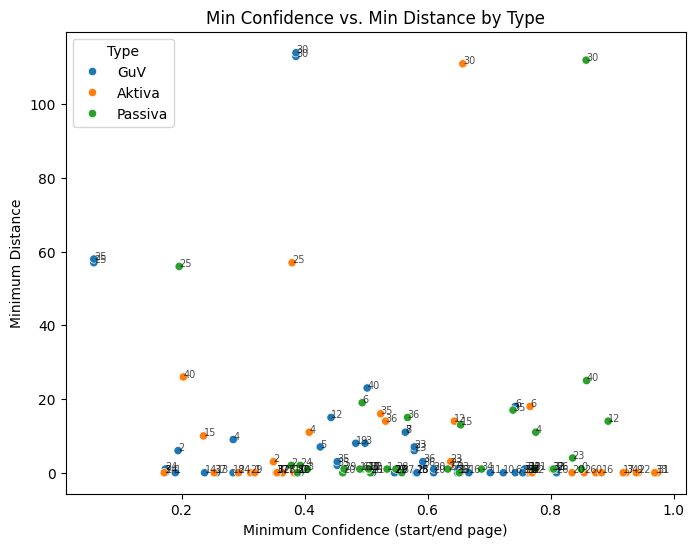

In [52]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the minimum confidence for each row
df_check["min_confidence"] = df_check[["confidence_start_page", "confidence_end_page"]].min(axis=1)
df_check["mean_confidence"] = df_check[["confidence_start_page", "confidence_end_page"]].mean(axis=1)
df_check["max_confidence"] = df_check[["confidence_start_page", "confidence_end_page"]].max(axis=1)
# Assign a unique integer to each unique filepath for annotation or coloring
df_check["path_id"] = df_check["filepath"].astype("category").cat.codes
df_check["min_confidence_path_group"] = df_check.groupby("path_id")["min_confidence"].transform("min")

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_check,  # [~df_check["in_range"]],
    x="min_confidence",
    y="min_distance",
    hue="type",
    palette="tab10"
)

# Annotate each point with the last part of the filepath (e.g., filename)
for i, row in df_check.iterrows():
    plt.text(
        row["min_confidence"],
        row["min_distance"],
        str(row["path_id"]),  # or: os.path.basename(row["filepath"]) if you want the filename
        fontsize=7,
        alpha=0.7
    )
plt.xlabel("Minimum Confidence (start/end page)")
plt.ylabel("Minimum Distance")
plt.title("Min Confidence vs. Min Distance by Type")
plt.legend(title="Type")
plt.show()

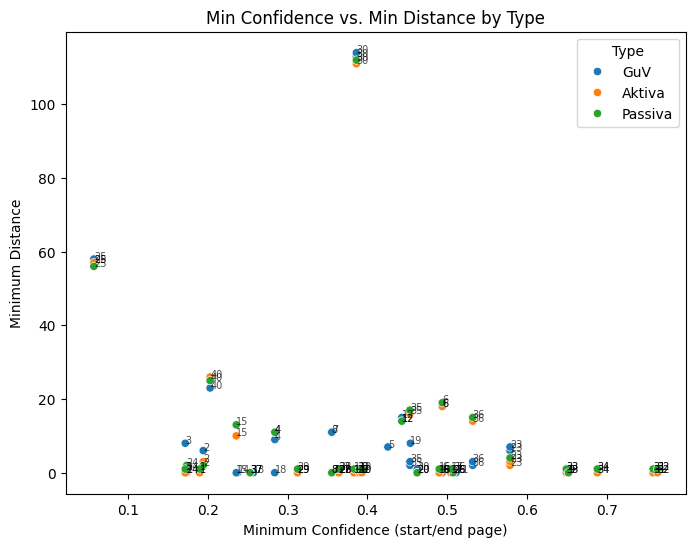

In [53]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_check,  # [~df_check["in_range"]],
    x="min_confidence_path_group",
    y="min_distance",
    hue="type",
    palette="tab10"
)

# Annotate each point with the last part of the filepath (e.g., filename)
for i, row in df_check.iterrows():
    plt.text(
        row["min_confidence_path_group"],
        row["min_distance"],
        str(row["path_id"]),  # or: os.path.basename(row["filepath"]) if you want the filename
        fontsize=7,
        alpha=0.7
    )
plt.xlabel("Minimum Confidence (start/end page)")
plt.ylabel("Minimum Distance")
plt.title("Min Confidence vs. Min Distance by Type")
plt.legend(title="Type")
plt.show()

<Axes: >

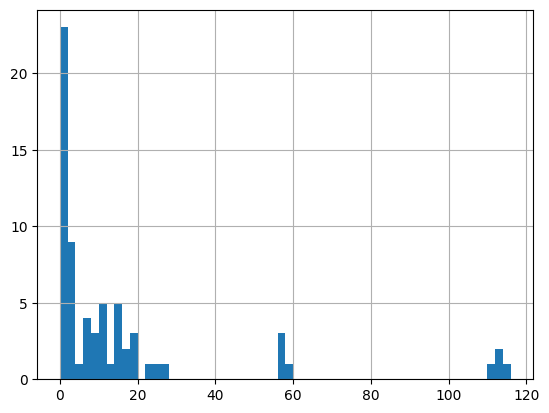

In [54]:
df_check[~df_check["in_range"]]["min_distance"].hist(bins=range(0, int(df_check["min_distance"].max()) + 3, 2))

In [55]:
df_check[df_check['min_distance']>80]

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page,page,_merge,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
17,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,5,5,0.386074,0.405523,118.0,both,False,113.0,0.386074,0.395799,0.405523,30,0.386074
18,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,5,5,0.386074,0.405523,119.0,both,False,114.0,0.386074,0.395799,0.405523,30,0.386074
70,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,Aktiva,5,5,0.657393,0.922713,116.0,both,False,111.0,0.657393,0.790053,0.922713,30,0.386074
115,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,Passiva,5,5,0.857822,0.997600,117.0,both,False,112.0,0.857822,0.927711,0.997600,30,0.386074


In [56]:
df_check[df_check['filepath'].str.contains("../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2012.pdf")]

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page,page,_merge,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
17,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,5,5,0.386074,0.405523,118.0,both,False,113.0,0.386074,0.395799,0.405523,30,0.386074
18,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,5,5,0.386074,0.405523,119.0,both,False,114.0,0.386074,0.395799,0.405523,30,0.386074
70,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,Aktiva,5,5,0.657393,0.922713,116.0,both,False,111.0,0.657393,0.790053,0.922713,30,0.386074
115,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,Passiva,5,5,0.857822,0.997600,117.0,both,False,112.0,0.857822,0.927711,0.997600,30,0.386074


In [57]:
df_check[(df_check['min_distance']<80) & (df_check['min_distance']>20)]

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page,page,_merge,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
23,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,10,11,0.057401,0.284601,68.0,both,False,57.0,0.057401,0.171001,0.284601,25,0.057401
24,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,10,11,0.057401,0.284601,69.0,both,False,58.0,0.057401,0.171001,0.284601,25,0.057401
49,../Geschaeftsberichte/degewo AG/212131_degewo_...,GuV,56,56,0.594211,0.501827,33.0,both,False,23.0,0.501827,0.548019,0.594211,40,0.202989
73,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,Aktiva,8,9,0.379730,0.819609,66.0,both,False,57.0,0.379730,0.599670,0.819609,25,0.057401
94,../Geschaeftsberichte/degewo AG/212131_degewo_...,Aktiva,56,56,0.202989,0.911838,30.0,both,False,26.0,0.202989,0.557414,0.911838,40,0.202989
118,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,Passiva,10,11,0.196187,0.954997,67.0,both,False,56.0,0.196187,0.575592,0.954997,25,0.057401
138,../Geschaeftsberichte/degewo AG/212131_degewo_...,Passiva,56,56,0.858673,0.995622,31.0,both,False,25.0,0.858673,0.927147,0.995622,40,0.202989


In [58]:
df_check.groupby("filepath").size()

filepath
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2014_BBB.pdf         3
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2016_BBB.pdf         3
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2018_BBB.pdf         3
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2019_BBB.pdf         3
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2023_BBB.pdf         3
../Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss_2021_BEN_GmbH.pdf                  3
../Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf                                     6
../Geschaeftsberichte/Berlinovo/Finanzbericht_Berlinovo_2022_bf_s.pdf                                   3
../Geschaeftsberichte/Berlinovo/Finanzbericht_Berlinovo_2022_s.pdf                                      3
../Geschaeftsberichte/Berlinovo/berli

In [59]:
df_check[df_check['filepath'].str.contains("../Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf")]

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page,page,_merge,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.979152,0.742657,10.0,both,True,0.0,0.742657,0.860905,0.979152,6,0.493731
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.979152,0.742657,28.0,both,False,18.0,0.742657,0.860905,0.979152,6,0.493731
60,../Geschaeftsberichte/Berliner Bäder Betriebe/...,Aktiva,7,7,0.908634,0.766817,7.0,both,True,0.0,0.766817,0.837726,0.908634,6,0.493731
61,../Geschaeftsberichte/Berliner Bäder Betriebe/...,Aktiva,7,7,0.908634,0.766817,25.0,both,False,18.0,0.766817,0.837726,0.908634,6,0.493731
105,../Geschaeftsberichte/Berliner Bäder Betriebe/...,Passiva,7,7,0.493731,0.876494,8.0,both,False,1.0,0.493731,0.685113,0.876494,6,0.493731
106,../Geschaeftsberichte/Berliner Bäder Betriebe/...,Passiva,7,7,0.493731,0.876494,26.0,both,False,19.0,0.493731,0.685113,0.876494,6,0.493731


In [60]:
[entry for entry in files_with_toc if "/Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf" in entry["path"]]

[{'path': '/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf',
  'toc': [[1, 'Lagebericht', 5],
   [1, 'Bilanz', 7],
   [1, 'Gewinn- und Verlustrechnung', 10],
   [1, 'Anhang', 13],
   [1, 'Lagebericht ', 17],
   [1, 'Bilanz', 25],
   [1, 'Anhang', 31],
   [1, 'Anlagenspiegel', 39],
   [1, 'Bestätigungsvermerk', 42]],
  'n_entries': 9,
  'markdown_toc': '|   hierarchy_level | title                       |   page_number |   enumeration |\n|------------------:|:----------------------------|--------------:|--------------:|\n|                 1 | Lagebericht                 |             5 |             1 |\n|                 1 | Bilanz                      |             7 |             2 |\n|                 1 | Gewinn- und Verlustrechnung |            10 |             3 |\n|                 1 | Anhang                      |            13 |             4 |\n|                 1 | Lagebericht                 |            17 |         

In [61]:
df_multientries = pd.DataFrame(df_check.groupby("filepath").size(), columns=['count']).reset_index().query("count > 4").reset_index()
df_multientries

,index,filepath,count
0,6,../Geschaeftsberichte/Berliner Bäder Betriebe/...,6
1,23,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,5


In [62]:
df_check[~df_check['filepath'].isin(df_multientries['filepath'])].groupby("in_range").size()

in_range
False    82
True     56
dtype: int64

In [63]:
small_toc = [file['path'].replace("/home/simon/Documents/data_science/Thesis", "..") for file in files_with_toc if file['n_entries'] <= 3]
small_toc

['../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2012.pdf',
 '../Geschaeftsberichte/Berlinovo/berlinovo_gb2019_s.pdf',
 '../Geschaeftsberichte/degewo AG/2019_degewo_Konzernbericht_und_Gleicher_Lohn_fuer_gleiche_Arbeit.pdf',
 '../Geschaeftsberichte/degewo AG/212131_degewo_2022_Konzernlagebericht_Konzernabschluss.pdf',
 '../Geschaeftsberichte/degewo AG/201231_degewo_Konzernlagebericht_Konzernabschluss.pdf',
 '../Geschaeftsberichte/degewo AG/240618-degewo-konzernlagerbericht-konzernabschluss-2023.pdf',
 '../Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss_2021_BEN_GmbH.pdf']

<Axes: xlabel='i'>

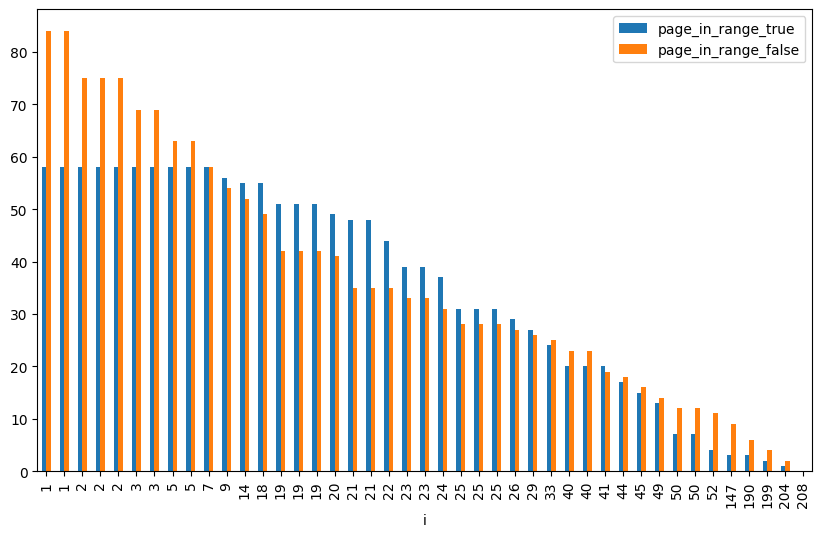

In [64]:
list = []

for i in [file['n_entries'] for file in files_with_toc]:
    small_toc = [file['path'].replace("/home/simon/Documents/data_science/Thesis", "..") for file in files_with_toc if file['n_entries'] <= i]
    page_in_range = df_check[~df_check['filepath'].isin(small_toc)].groupby("in_range").size()
    list.append({
        "i": i,
        "page_in_range_true": page_in_range.get(True, 0),
        "page_in_range_false": page_in_range.get(False, 0)
    })
    # print(f"i: {i}, page_in_range: {page_in_range}")

pd.DataFrame(list).sort_values(by="i", ascending=True).set_index("i").plot(kind="bar", figsize=(10, 6))

In [65]:
df_check

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page,page,_merge,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.979152,0.742657,10.0,both,True,0.0,0.742657,0.860905,0.979152,6,0.493731
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.979152,0.742657,28.0,both,False,18.0,0.742657,0.860905,0.979152,6,0.493731
2,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,44,44,0.949846,0.761699,44.0,both,True,0.0,0.761699,0.855772,0.949846,34,0.687908
3,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,44,44,0.949846,0.761699,45.0,both,False,1.0,0.761699,0.855772,0.949846,34,0.687908
4,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,GuV,6,6,0.986772,0.387530,6.0,both,True,0.0,0.387530,0.687151,0.986772,22,0.387530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,45,47,0.572889,0.809096,NaN,left_only,False,NaN,0.572889,0.690993,0.809096,18,0.283894
145,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,40,40,0.489906,0.980528,41.0,both,False,1.0,0.489906,0.735217,0.980528,16,0.489906
146,../Geschaeftsberichte/GESOBAU AG/Gesch%C3%A4ft...,Passiva,39,41,0.876158,0.681953,NaN,left_only,False,NaN,0.681953,0.779056,0.876158,19,0.453748
147,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,40,40,0.504354,0.981148,41.0,both,False,1.0,0.504354,0.742751,0.981148,17,0.504354


# TOC from text

## 5 pages approach

In [42]:
import json


with open("../../Python/pdf_texts.json", "r") as f:
    data = json.load(f)

In [95]:
from pydantic import BaseModel

class TOC(BaseModel):
    toc: str

json_schema = TOC.model_json_schema()
json_schema

{'properties': {'toc': {'title': 'Toc', 'type': 'string'}},
 'required': ['toc'],
 'title': 'TOC',
 'type': 'object'}

In [96]:
import re 

i = 5  # Number of pages to consider for the TOC

results = []
idx = 0

for key, value in data.items():
    idx += 1
    print(f"Processing file {idx}/{len(data)}: {key}")
    start_pages = "\n".join(value[0:5])
    start_pages = re.sub(r"(\.\s*){3,}", r"\.\.\.", start_pages)

    messages = [
        {"role": "system", "content": "[Role] You are a helpful assistant that can identify table of contents in a German financial report."},
        {"role": "system", "content": f"[Context] These are the text lines of the first {i} pages:\n\n{start_pages}"},
        {"role": "user", "content": f"[Tasks] 1. Please identify if there is a table of contents in the text."},
        {"role": "user", "content": f"2. If there is a table of contents, please extract its text."},
        {"role": "user", "content": f"3. Answer as JSON with the table of contents text as string in the key 'toc'."},
        {"role": "user", "content": f"If there is no table of contents, return an empty string."},
    ]

    completion = client.chat.completions.create(
        model=model,
        messages=combine_messages(messages),
        extra_body={
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "toc",
                    "schema": json_schema
                },
            },
        },
        logprobs=1,
        temperature=0,
        max_tokens=5000,  # Increased to handle larger TOC responses
    )

    result = completion.choices[0].message.content
    try:
        result_json = json.loads(result)
    except json.JSONDecodeError:
        print(f"Error decoding JSON for file {key}: {result}")
        result_json = {"toc": result}
    result_json["file_path"] = key
    results.append(result_json)

Processing file 1/80: /pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss-BEN-GmbH-2023.pdf
Processing file 2/80: /pvc/Geschaeftsberichte/Berlin Energie und Netzholding/SIGNATURE_DEE00084236.1.1_550912_Endexemplar_20230331.pdf
Processing file 3/80: /pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss_2021_BEN_GmbH.pdf
Processing file 4/80: /pvc/Geschaeftsberichte/degewo AG/degewo_Konzernlagebericht_Konzernabschluss_2022.pdf
Processing file 5/80: /pvc/Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf
Processing file 6/80: /pvc/Geschaeftsberichte/degewo AG/201231_degewo_Konzernlagebericht_Konzernabschluss.pdf
Processing file 7/80: /pvc/Geschaeftsberichte/degewo AG/212131_degewo_2022_Konzernlagebericht_Konzernabschluss.pdf
Processing file 8/80: /pvc/Geschaeftsberichte/degewo AG/2019_degewo_Konzernbericht_und_Gleicher_Lohn_fuer_gleiche_Arbeit.pdf
Processing file 9/80: /pvc/Geschaeftsberichte/degewo AG/240618-degewo-konzernlagerbericht-konzern

In [97]:
results_toc_extraction = results
results_toc_extraction

[{'toc': 'Inhaltsverzeichnis Seite\n\nLagebericht/.1\n1. Erklärung zum Berliner Corporate Governance Kodex - Anlage zum Lagebericht/.13\nJahresabschluss für das Geschäftsjahr vom 1. Januar bis 31. Dezember 2023/.1\n1. Bilanz zum 31. Dezember 2023/.3\n2. Gewinn- und Verlustrechnung für die Zeit vom 1. Januar bis 31. Dezember 2023/.5\n3. Anhang für das Geschäftsjahr 2023/.1\nAnlagenspiegel/.11\nTätigkeitsabschlüsse/.1\nBESTÄTIGUNGSVERMERK DES UNABHÄNGIGEN ABSCHLUSSPRÜFERS/.1',
  'file_path': '/pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss-BEN-GmbH-2023.pdf'},
 {'toc': 'Inhaltsverzeichnis Seite\n\n1. Erklärung zum Berliner Corporate Governance Kodex - Anlage zum Lagebericht\n13\n\nJahresabschluss für das Geschäftsjahr vom 1. Januar bis 31. Dezember 2022\n1\n\n1. Bilanz zum 31. Dezember 2022\n2\n\n2. Gewinn- und Verlustrechnung für die Zeit vom 1. Januar bis 31. Dezember 2022\n5\n\n3. Anhang für das Geschäftsjahr 2022\n1\n\nAnlagenspiegel\n11\n\nTätigkeitsabschlüsse

In [98]:
extracted_tocs = [r["toc"] for r in results_toc_extraction if r["toc"] != ""]
len(extracted_tocs)

67

## looping

In [99]:
import json
from pydantic import BaseModel

class PageRange(BaseModel):
    start: int
    end: int

class TOC(BaseModel):
    GuV: PageRange
    Aktiva: PageRange
    Passiva: PageRange

json_schema = TOC.model_json_schema()

page_range_result2 = []

for idx, entry in enumerate(r for r in results_toc_extraction if r["toc"] != ""):
    print(f"Processing file {idx + 1}/{len(extracted_tocs)}:")
    toc_string = entry["toc"]

    messages = [
        {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
        {"role": "user", "content": f"This is the table of contents:\n\n{toc_string}"},
        {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (in German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
        # {"role": "user", "content": f"The assets and liabilities are part of the balance sheet (in German: Bilanz). The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
        {"role": "user", "content": f"The assets and liabilities are part of the balance sheet (in German: Bilanz). The liabilities table is often on the page after the assets table. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
        {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
    ]

    completion = client.chat.completions.create(
        model=model,
        messages=combine_messages(messages),
        extra_body={
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "toc",
                    "schema": json_schema
                },
            },
        },
        max_tokens=1000,
        logprobs=1,
        temperature=0,
    )

    result = completion.choices[0].message.content
    result_json = json.loads(result)
    result_json["file_path"] = entry["file_path"]
    result_json["toc"] = toc_string

    logprobs = getattr(completion.choices[0], "logprobs", None)
    digit_logprobs = calculate_confidence_for_integers(logprobs) if logprobs else None
    result_json["logprobs"] = {'GuV': digit_logprobs[0:2], 'Aktiva': digit_logprobs[2:4], 'Passiva': digit_logprobs[4:]}

    page_range_result2.append(result_json)


Processing file 1/67:
Processing file 2/67:
Processing file 3/67:
Processing file 4/67:
Processing file 5/67:
Processing file 6/67:
Processing file 7/67:
Processing file 8/67:
Processing file 9/67:
Processing file 10/67:
Processing file 11/67:
Processing file 12/67:
Processing file 13/67:
Processing file 14/67:
Processing file 15/67:
Processing file 16/67:
Processing file 17/67:
Processing file 18/67:
Processing file 19/67:
Processing file 20/67:
Processing file 21/67:
Processing file 22/67:
Processing file 23/67:
Processing file 24/67:
Processing file 25/67:
Processing file 26/67:
Processing file 27/67:
Processing file 28/67:
Processing file 29/67:
Processing file 30/67:
Processing file 31/67:
Processing file 32/67:
Processing file 33/67:
Processing file 34/67:
Processing file 35/67:
Processing file 36/67:
Processing file 37/67:
Processing file 38/67:
Processing file 39/67:
Processing file 40/67:
Processing file 41/67:
Processing file 42/67:
Processing file 43/67:
Processing file 44/6

In [100]:
page_range_result2

[{'GuV': {'start': 5, 'end': 5},
  'Aktiva': {'start': 3, 'end': 3},
  'Passiva': {'start': 4, 'end': 4},
  'file_path': '/pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss-BEN-GmbH-2023.pdf',
  'toc': 'Inhaltsverzeichnis Seite\n\nLagebericht/.1\n1. Erklärung zum Berliner Corporate Governance Kodex - Anlage zum Lagebericht/.13\nJahresabschluss für das Geschäftsjahr vom 1. Januar bis 31. Dezember 2023/.1\n1. Bilanz zum 31. Dezember 2023/.3\n2. Gewinn- und Verlustrechnung für die Zeit vom 1. Januar bis 31. Dezember 2023/.5\n3. Anhang für das Geschäftsjahr 2023/.1\nAnlagenspiegel/.11\nTätigkeitsabschlüsse/.1\nBESTÄTIGUNGSVERMERK DES UNABHÄNGIGEN ABSCHLUSSPRÜFERS/.1',
  'logprobs': {'GuV': [{'number': 5,
     'confidence': np.float64(0.895832520606711)},
    {'number': 5, 'confidence': np.float64(0.7512390526680321)}],
   'Aktiva': [{'number': 3, 'confidence': np.float64(0.9627735036725404)},
    {'number': 3, 'confidence': np.float64(0.935960529601488)}],
   'Passiva':

In [101]:
import json

df_result2 = pd.DataFrame(page_range_result2)
df_result2['file_path'] = df_result2['file_path'].apply(lambda x: x.replace("/pvc/", "../"))  # Ensure file_path is string type
# Melt the DataFrame to long format, keeping 'file_path' as id
df_long2 = df_result2.melt(id_vars=["file_path", "logprobs", "toc"], var_name="type", value_name="page_range")
df_long2["logprobs"] = df_long2.apply(lambda x: x.get("logprobs").get(x["type"]) if x.get("logprobs") else None, axis=1)
# Convert the 'page_range' column from JSON string to dict if necessary

# If page_range is already a dict, this will do nothing; otherwise, it will parse the string
# df_long["page_range"] = df_long["page_range"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Split into two new columns
df_long2["start_page"] = df_long2["page_range"].apply(lambda x: x["start"])
df_long2["end_page"] = df_long2["page_range"].apply(lambda x: x["end"])
df_long2 = df_long2.drop(columns=["page_range"])
df_long2.rename(columns={"file_path": "filepath"}, inplace=True)
df_long2["confidence_start_page"] = df_long2["logprobs"].apply(lambda x: x[0].get("confidence") if x else None)
df_long2["confidence_end_page"] = df_long2["logprobs"].apply(lambda x: x[1].get("confidence") if x else None)
df_long2 = df_long2.drop(columns=["logprobs"])

df_long2

,filepath,toc,type,start_page,end_page,confidence_start_page,confidence_end_page
0,../Geschaeftsberichte/Berlin Energie und Netzh...,Inhaltsverzeichnis Seite\n\nLagebericht/.1\n1....,GuV,5,5,0.895833,0.751239
1,../Geschaeftsberichte/Berlin Energie und Netzh...,Inhaltsverzeichnis Seite\n\n1. Erklärung zum B...,GuV,5,5,0.756159,0.592587
2,../Geschaeftsberichte/Berlin Energie und Netzh...,Inhaltsverzeichnis,GuV,10,15,0.203282,0.480968
3,../Geschaeftsberichte/degewo AG/degewo_Konzern...,Konzernabschluss hr vom 1. Januar 2022 - 31. D...,GuV,10,15,0.153700,0.360230
4,../Geschaeftsberichte/degewo AG/240618-degewo-...,Zusammengefasster Lagebericht\n1. Grundlagen\n...,GuV,10,15,0.176012,0.397946
...,...,...,...,...,...,...,...
196,../Geschaeftsberichte/Amt für Statistik Berlin...,2 Vorwort des Vorstandes\nOrganisation 4\n6 Bi...,Passiva,7,8,0.754366,0.936606
197,../Geschaeftsberichte/Amt für Statistik Berlin...,2 Vorwort des Vorstandes\nOrganisation 4\n6 Bi...,Passiva,7,8,0.730861,0.935373
198,../Geschaeftsberichte/Amt für Statistik Berlin...,Inhaltsverzeichnis\n2 Vorwort des Vorstandes\n...,Passiva,17,17,0.821064,0.991564
199,../Geschaeftsberichte/Amt für Statistik Berlin...,Inhaltsverzeichnis\n2 Vorwort des Vorstandes\n...,Passiva,24,24,0.519649,0.787751


In [102]:
df_check2 = df.merge(df_long2, on=["filepath", "type"], how="right")
df_check2["in_range"] = df_check2.apply(lambda row: row["start_page"] <= row["page"] <= row["end_page"], axis=1)
df_check2['min_distance'] = df_check2.apply(lambda row: min(abs(row["start_page"] - row["page"]), abs(row["end_page"] - row["page"])) if not row["in_range"] else 0, axis=1)

df_check2

,filepath,page,type,toc,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance
0,../Geschaeftsberichte/Berlin Energie und Netzh...,23.0,GuV,Inhaltsverzeichnis Seite\n\nLagebericht/.1\n1....,5,5,0.895833,0.751239,False,18.0
1,../Geschaeftsberichte/Berlin Energie und Netzh...,43.0,GuV,Inhaltsverzeichnis Seite\n\nLagebericht/.1\n1....,5,5,0.895833,0.751239,False,38.0
2,../Geschaeftsberichte/Berlin Energie und Netzh...,23.0,GuV,Inhaltsverzeichnis Seite\n\n1. Erklärung zum B...,5,5,0.756159,0.592587,False,18.0
3,../Geschaeftsberichte/Berlin Energie und Netzh...,43.0,GuV,Inhaltsverzeichnis Seite\n\n1. Erklärung zum B...,5,5,0.756159,0.592587,False,38.0
4,../Geschaeftsberichte/Berlin Energie und Netzh...,10.0,GuV,Inhaltsverzeichnis,10,15,0.203282,0.480968,True,0.0
...,...,...,...,...,...,...,...,...,...,...
231,../Geschaeftsberichte/Amt für Statistik Berlin...,9.0,Passiva,2 Vorwort des Vorstandes\nOrganisation 4\n6 Bi...,7,8,0.754366,0.936606,False,1.0
232,../Geschaeftsberichte/Amt für Statistik Berlin...,9.0,Passiva,2 Vorwort des Vorstandes\nOrganisation 4\n6 Bi...,7,8,0.730861,0.935373,False,1.0
233,../Geschaeftsberichte/Amt für Statistik Berlin...,19.0,Passiva,Inhaltsverzeichnis\n2 Vorwort des Vorstandes\n...,17,17,0.821064,0.991564,False,2.0
234,../Geschaeftsberichte/Amt für Statistik Berlin...,27.0,Passiva,Inhaltsverzeichnis\n2 Vorwort des Vorstandes\n...,24,24,0.519649,0.787751,False,3.0


In [103]:
df_check2.groupby("in_range").size()

in_range
False    204
True      32
dtype: int64

In [104]:
df_check2.groupby(["type", "in_range"]).size()

type     in_range
Aktiva   False       64
         True         8
GuV      False       76
         True        17
Passiva  False       64
         True         7
dtype: int64

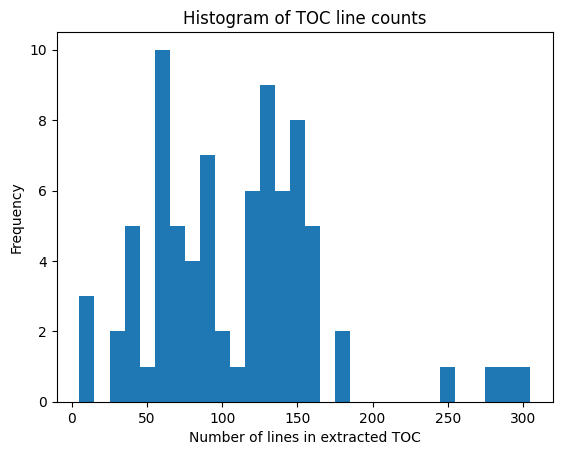

In [105]:
n_lines = [len("\n".join(value[0:5]).split("\n")) for key, value in data.items()]

import matplotlib.pyplot as plt

plt.hist(n_lines, bins=30)
plt.xlabel("Number of lines in extracted TOC")
plt.ylabel("Frequency")
plt.title("Histogram of TOC line counts")
plt.show()

# 200 lines approach

In [43]:
from pydantic import BaseModel

class TOC(BaseModel):
    toc: str

json_schema = TOC.model_json_schema()
json_schema

{'properties': {'toc': {'title': 'Toc', 'type': 'string'}},
 'required': ['toc'],
 'title': 'TOC',
 'type': 'object'}

In [44]:
import re 

results = []
idx = 0

for key, value in data.items():
    idx += 1
    print(f"Processing file {idx}/{len(data)}: {key}")
    start_pages = "\n".join("\n".join(value).split("\n")[:200])  # Take only the first 200 lines
    start_pages = re.sub(r"(\.\s*){3,}", r"\.\.\.", start_pages)

    messages = [
        {"role": "system", "content": "[Role] You are a helpful assistant that can identify table of contents in a German financial report."},
        {"role": "system", "content": f"[Context] These are the text lines of the first {i} pages:\n\n{start_pages}"},
        {"role": "user", "content": f"[Tasks] 1. Please identify if there is a table of contents in the text."},
        {"role": "user", "content": f"2. If there is a table of contents, please extract its text."},
        {"role": "user", "content": f"3. Answer as JSON with the table of contents text as string in the key 'toc'."},
        {"role": "user", "content": f"If there is no table of contents, return an empty string."},
    ]

    completion = client.chat.completions.create(
        model=model,
        messages=combine_messages(messages),
        extra_body={
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "toc",
                    "schema": json_schema
                },
            },
        },
        logprobs=1,
        temperature=0,
        max_tokens=5000,  # Increased to handle larger TOC responses
    )

    result = completion.choices[0].message.content
    try:
        result_json = json.loads(result)
    except json.JSONDecodeError:
        print(f"Error decoding JSON for file {key}: {result}")
        result_json = {"toc": result}
    result_json["file_path"] = key
    results.append(result_json)

Processing file 1/80: /pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss-BEN-GmbH-2023.pdf
Processing file 2/80: /pvc/Geschaeftsberichte/Berlin Energie und Netzholding/SIGNATURE_DEE00084236.1.1_550912_Endexemplar_20230331.pdf
Processing file 3/80: /pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss_2021_BEN_GmbH.pdf
Processing file 4/80: /pvc/Geschaeftsberichte/degewo AG/degewo_Konzernlagebericht_Konzernabschluss_2022.pdf
Processing file 5/80: /pvc/Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf
Processing file 6/80: /pvc/Geschaeftsberichte/degewo AG/201231_degewo_Konzernlagebericht_Konzernabschluss.pdf
Processing file 7/80: /pvc/Geschaeftsberichte/degewo AG/212131_degewo_2022_Konzernlagebericht_Konzernabschluss.pdf
Processing file 8/80: /pvc/Geschaeftsberichte/degewo AG/2019_degewo_Konzernbericht_und_Gleicher_Lohn_fuer_gleiche_Arbeit.pdf
Processing file 9/80: /pvc/Geschaeftsberichte/degewo AG/240618-degewo-konzernlagerbericht-konzern

In [45]:
results_toc_extraction2 = results
results_toc_extraction2

[{'toc': 'Inhaltsverzeichnis Seite\nGrundlagen des Unternehmens \n1.1 Gesellschaftsrechtliche Struktur\n1.2 Ziele und Strategien \nWirtschaftsbericht \n2.1 Politische und wirtschaftliche Rahmenbedingungen \n2.2 Geschäftsverlauf \n2.3 Lage \nErtragslage \nVermögenslage \nFinanzlage \nChancen- und Risikobericht \nPrognosebericht',
  'file_path': '/pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss-BEN-GmbH-2023.pdf'},
 {'toc': 'Inhaltsverzeichnis Seite\nGrundlagen des Unternehmens \n1.1 Gesellschaftsrechtliche Struktur\n1.2 Ziele und Strategien \nWirtschaftsbericht \n2.1 Politische und wirtschaftliche Rahmenbedingungen\n2.2 Geschäftsverlauf\n2.3 Lage\nErtragslage\nVermögenslage\nFinanzlage\nChancen- und Risikobericht\nPrognosebericht',
  'file_path': '/pvc/Geschaeftsberichte/Berlin Energie und Netzholding/SIGNATURE_DEE00084236.1.1_550912_Endexemplar_20230331.pdf'},
 {'toc': 'Inhaltsverzeichnis\n\nAllgemeine Hinweise \nBilanzierungs- und Bewertungsmethoden\nErläuterunge

In [46]:
extracted_tocs2 = [r["toc"] for r in results_toc_extraction2 if r["toc"] != ""]
len(extracted_tocs2)

70

## looping

In [48]:
import json
from pydantic import BaseModel

class PageRange(BaseModel):
    start: int
    end: int

class TOC(BaseModel):
    GuV: PageRange
    Aktiva: PageRange
    Passiva: PageRange

json_schema = TOC.model_json_schema()

page_range_result3 = []

for idx, entry in enumerate(r for r in results_toc_extraction2 if r["toc"] != ""):
    print(f"Processing file {idx + 1}/{len(extracted_tocs2)}:")
    # print(entry)
    toc_string = entry["toc"]


    messages = [
        {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
        {"role": "user", "content": f"This is the table of contents:\n\n{toc_string}"},
        {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (in German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
        # {"role": "user", "content": f"The assets and liabilities are part of the balance sheet (in German: Bilanz). The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
        {"role": "user", "content": f"The assets and liabilities are part of the balance sheet (in German: Bilanz). The liabilities table is often on the page after the assets table. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
        {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
    ]
    
    # messages = [
    #     {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    #     {"role": "user", "content": f"This is the table of contents:\n\n{toc_string}"},
    #     {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    #     {"role": "user", "content": f"The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
    #     {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
    # ]

    completion = client.chat.completions.create(
        model=model,
        messages=combine_messages(messages),
        extra_body={
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "toc",
                    "schema": json_schema
                },
            },
        },
        logprobs=1,
        temperature=0,
    )

    result = completion.choices[0].message.content
    result_json = json.loads(result)
    result_json["file_path"] = entry["file_path"]
    result_json["toc"] = toc_string

    logprobs = getattr(completion.choices[0], "logprobs", None)
    digit_logprobs = calculate_confidence_for_integers(logprobs) if logprobs else None
    result_json["logprobs"] = {'GuV': digit_logprobs[0:2], 'Aktiva': digit_logprobs[2:4], 'Passiva': digit_logprobs[4:]}

    page_range_result3.append(result_json)


Processing file 1/70:
Processing file 2/70:
Processing file 3/70:
Processing file 4/70:
Processing file 5/70:
Processing file 6/70:
Processing file 7/70:
Processing file 8/70:
Processing file 9/70:
Processing file 10/70:
Processing file 11/70:
Processing file 12/70:
Processing file 13/70:
Processing file 14/70:
Processing file 15/70:
Processing file 16/70:
Processing file 17/70:
Processing file 18/70:
Processing file 19/70:
Processing file 20/70:
Processing file 21/70:
Processing file 22/70:
Processing file 23/70:
Processing file 24/70:
Processing file 25/70:
Processing file 26/70:
Processing file 27/70:
Processing file 28/70:
Processing file 29/70:
Processing file 30/70:
Processing file 31/70:
Processing file 32/70:
Processing file 33/70:
Processing file 34/70:
Processing file 35/70:
Processing file 36/70:
Processing file 37/70:
Processing file 38/70:
Processing file 39/70:
Processing file 40/70:
Processing file 41/70:
Processing file 42/70:
Processing file 43/70:
Processing file 44/7

In [111]:
page_range_result3

[{'GuV': {'start': 23, 'end': 24},
  'Aktiva': {'start': 21, 'end': 22},
  'Passiva': {'start': 22, 'end': 23},
  'file_path': '/pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss-BEN-GmbH-2023.pdf',
  'toc': 'Inhaltsverzeichnis Seite\nGrundlagen des Unternehmens \n1.1 Gesellschaftsrechtliche Struktur\n1.2 Ziele und Strategien \nWirtschaftsbericht \n2.1 Politische und wirtschaftliche Rahmenbedingungen \n2.2 Geschäftsverlauf \n2.3 Lage \nErtragslage \nVermögenslage \nFinanzlage \nChancen- und Risikobericht \nPrognosebericht',
  'logprobs': {'GuV': [{'number': 23,
     'confidence': np.float64(0.05682626744434512)},
    {'number': 24, 'confidence': np.float64(0.1446706429696591)}],
   'Aktiva': [{'number': 21, 'confidence': np.float64(0.17826608125050922)},
    {'number': 22, 'confidence': np.float64(0.8307480923518485)}],
   'Passiva': [{'number': 22, 'confidence': np.float64(0.7048585681524453)},
    {'number': 23, 'confidence': np.float64(0.9751930340813366)}]}},
 {

In [112]:
import json

df_result3 = pd.DataFrame(page_range_result3)
df_result3['file_path'] = df_result3['file_path'].apply(lambda x: x.replace("/pvc/", "../"))  # Ensure file_path is string type
# Melt the DataFrame to long format, keeping 'file_path' as id
df_long3 = df_result3.melt(id_vars=["file_path", "logprobs", "toc"], var_name="type", value_name="page_range")
df_long3["logprobs"] = df_long3.apply(lambda x: x.get("logprobs").get(x["type"]) if x.get("logprobs") else None, axis=1)
# Convert the 'page_range' column from JSON string to dict if necessary

# If page_range is already a dict, this will do nothing; otherwise, it will parse the string
# df_long["page_range"] = df_long["page_range"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Split into two new columns
df_long3["start_page"] = df_long3["page_range"].apply(lambda x: x["start"])
df_long3["end_page"] = df_long3["page_range"].apply(lambda x: x["end"])
df_long3 = df_long3.drop(columns=["page_range"])
df_long3.rename(columns={"file_path": "filepath"}, inplace=True)
df_long3["confidence_start_page"] = df_long3["logprobs"].apply(lambda x: x[0].get("confidence") if x else None)
df_long3["confidence_end_page"] = df_long3["logprobs"].apply(lambda x: x[1].get("confidence") if x else None)
df_long3 = df_long3.drop(columns=["logprobs"])

df_long3

,filepath,toc,type,start_page,end_page,confidence_start_page,confidence_end_page
0,../Geschaeftsberichte/Berlin Energie und Netzh...,Inhaltsverzeichnis Seite\nGrundlagen des Unter...,GuV,23,24,0.056826,0.144671
1,../Geschaeftsberichte/Berlin Energie und Netzh...,Inhaltsverzeichnis Seite\nGrundlagen des Unter...,GuV,10,15,0.084570,0.305937
2,../Geschaeftsberichte/Berlin Energie und Netzh...,Inhaltsverzeichnis\n\nAllgemeine Hinweise \nBi...,GuV,10,15,0.155684,0.414897
3,../Geschaeftsberichte/degewo AG/degewo_Konzern...,Konzernabschluss hr vom 1. Januar 2022 - 31. D...,GuV,10,15,0.206722,0.413562
4,../Geschaeftsberichte/degewo AG/240618-degewo-...,Zusammengefasster Lagebericht\n1. Grundlagen\n...,GuV,10,15,0.160623,0.397056
...,...,...,...,...,...,...,...
208,../Geschaeftsberichte/Amt für Statistik Berlin...,2021\nGeschäftsbericht\nI\nM\nP\nR\nE\nS\nS\nU...,Passiva,7,8,0.746981,0.942836
209,../Geschaeftsberichte/Amt für Statistik Berlin...,2022\nGeschäftsbericht\nI\nM\nP\nR\nE\nS\nS\nU...,Passiva,7,8,0.747508,0.942736
210,../Geschaeftsberichte/Amt für Statistik Berlin...,Inhaltsverzeichnis\n2 Vorwort des Vorstandes\n...,Passiva,17,17,0.820654,0.990632
211,../Geschaeftsberichte/Amt für Statistik Berlin...,Inhaltsverzeichnis\n2 Vorwort des Vorstandes\n...,Passiva,24,24,0.602387,0.868001


In [113]:
df_check3 = df.merge(df_long3, on=["filepath", "type"], how="right")
df_check3["in_range"] = df_check3.apply(lambda row: row["start_page"] <= row["page"] <= row["end_page"], axis=1)
df_check3['min_distance'] = df_check3.apply(lambda row: min(abs(row["start_page"] - row["page"]), abs(row["end_page"] - row["page"])) if not row["in_range"] else 0, axis=1)

df_check3

,filepath,page,type,toc,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance
0,../Geschaeftsberichte/Berlin Energie und Netzh...,23.0,GuV,Inhaltsverzeichnis Seite\nGrundlagen des Unter...,23,24,0.056826,0.144671,True,0.0
1,../Geschaeftsberichte/Berlin Energie und Netzh...,43.0,GuV,Inhaltsverzeichnis Seite\nGrundlagen des Unter...,23,24,0.056826,0.144671,False,19.0
2,../Geschaeftsberichte/Berlin Energie und Netzh...,23.0,GuV,Inhaltsverzeichnis Seite\nGrundlagen des Unter...,10,15,0.084570,0.305937,False,8.0
3,../Geschaeftsberichte/Berlin Energie und Netzh...,43.0,GuV,Inhaltsverzeichnis Seite\nGrundlagen des Unter...,10,15,0.084570,0.305937,False,28.0
4,../Geschaeftsberichte/Berlin Energie und Netzh...,10.0,GuV,Inhaltsverzeichnis\n\nAllgemeine Hinweise \nBi...,10,15,0.155684,0.414897,True,0.0
...,...,...,...,...,...,...,...,...,...,...
245,../Geschaeftsberichte/Amt für Statistik Berlin...,9.0,Passiva,2021\nGeschäftsbericht\nI\nM\nP\nR\nE\nS\nS\nU...,7,8,0.746981,0.942836,False,1.0
246,../Geschaeftsberichte/Amt für Statistik Berlin...,9.0,Passiva,2022\nGeschäftsbericht\nI\nM\nP\nR\nE\nS\nS\nU...,7,8,0.747508,0.942736,False,1.0
247,../Geschaeftsberichte/Amt für Statistik Berlin...,19.0,Passiva,Inhaltsverzeichnis\n2 Vorwort des Vorstandes\n...,17,17,0.820654,0.990632,False,2.0
248,../Geschaeftsberichte/Amt für Statistik Berlin...,27.0,Passiva,Inhaltsverzeichnis\n2 Vorwort des Vorstandes\n...,24,24,0.602387,0.868001,False,3.0


In [114]:
df_check3.groupby("in_range").size()

in_range
False    209
True      41
dtype: int64

In [115]:
df_check3.groupby(["type", "in_range"]).size()

type     in_range
Aktiva   False       67
         True         9
GuV      False       75
         True        24
Passiva  False       67
         True         8
dtype: int64

# Save results

In [116]:
toc_results = {
    "machine_readable_toc": df_check.to_dict(orient="records"),
    "toc_extraction_results_5_pages": df_check2.to_dict(orient="records"),
    "toc_extraction_results_200_lines": df_check3.to_dict(orient="records"),
}

with open("../../benchmark_results/page_identification/toc_results_mistral_8B_balance_details_next_page_promt.json", "w") as f:
    json.dump(toc_results, f, indent=4)